In [ ]:
%pip install -U langgraph

In [ ]:
!pip install -U langchain-ollama

In [ ]:
!pip install -U langchain-huggingface

In [ ]:
!pip install pypdf

In [ ]:
######

In [ ]:
!pip show langgraph

In [10]:
dir(langgraph.graph.StateGraph)

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_schema',
 '_all_edges',
 'add_conditional_edges',
 'add_edge',
 'add_node',
 'add_sequence',
 'compile',
 'set_conditional_entry_point',
 'set_entry_point',
 'set_finish_point',
 'validate']

In [10]:
dir(langgraph.graph)

['END',
 'Graph',
 'MessageGraph',
 'MessagesState',
 'START',
 'StateGraph',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'add_messages',
 'graph',
 'message',
 'state']

In [18]:
dir(langgraph.graph.Graph)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_all_edges',
 'add_conditional_edges',
 'add_edge',
 'add_node',
 'compile',
 'set_conditional_entry_point',
 'set_entry_point',
 'set_finish_point',
 'validate']

In [ ]:
######

In [1]:
import langgraph
from langgraph import graph

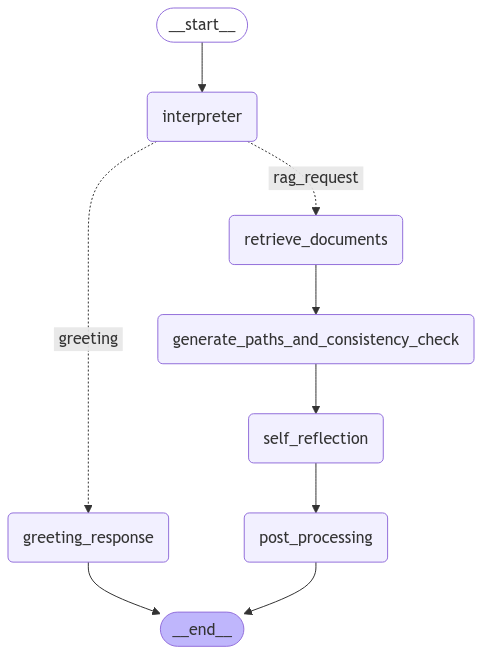

In [3]:
import openai
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict, Annotated
from langchain.prompts import PromptTemplate
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
import os

# Step 1: Configure OpenAI Client
client = openai.OpenAI(
    base_url='http://localhost:11434/v1',
    api_key='ollama'
)

MODEL = "llama3.2:latest"

# Step 2: Define State
class OverallState(TypedDict):
    query: str
    messages: list[dict]  # To store all interactions
    full_query: str
    document_context: str
    temp_response: str

# Step 3: Interpreter NODE
def interpreter_node(state: OverallState) -> OverallState:
    """Interpret the query and classify the intent."""
    query = state["query"]
    prompt = f"""
        Your task is to classify the intent of the user query into one of the following categories: [greeting, rag_request].
        The final response or classification should be just the word, nothing else.

        Intent Definitions:
        - greeting: If the Query is simply a greeting from the user.
        - rag_request: If the Query is potentially a domain related query.

        User Query: {query}
        Intent Classifier:
    """
    response = client.chat.completions.create(
        model=MODEL,
        messages=[
            {"role": "system", "content": "You are an intent classifier bot."},
            {"role": "user", "content": prompt}
        ],
        temperature=0
    )

    gen_response = response.choices[0].message.content
    state["temp_response"] = gen_response
#    state["messages"].append({"role": "user", "content": query})
    
    return state

# Step 4: Greeting Response NODE
def greeting_response_node(state: OverallState) -> OverallState:
    """Respond to the greeting from the user."""
    query = state["query"]
    prompt = f"""
        You are an AI Assistant Chatbot here to assist users. Respond to the user's greeting 
        appropriately and ask how you may help them.

        User Greeting: {query}
        AI Assistant:
    """
    response = client.chat.completions.create(
        model=MODEL,
        messages=[
            {"role": "system", "content": "You are a helpful AI assistant."},
            {"role": "user", "content": prompt}
        ],
        temperature=0
    )
    
    gen_response = response.choices[0].message.content
    state["messages"].append({"role": "assistant", "content": gen_response})
    state["temp_response"] = gen_response
    
    return state

# Step 5: Local Document Loader
def load_local_documents(folder_path):
    """Load all PDF files from a folder as documents."""
    documents = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".pdf"):
            loader = PyPDFLoader(os.path.join(folder_path, file_name))
            documents.extend(loader.load())
            
    return documents

# Step 6: Process and Index Documents
def create_document_store(folder_path):
    """Create a FAISS-based document store from local documents."""
    documents = load_local_documents(folder_path)
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
    texts = text_splitter.split_documents(documents)
    embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    vectorstore = FAISS.from_documents(texts, embedding_model)
    
    return vectorstore

# Initialize document store
current_directory = os.getcwd()
document_store = create_document_store(folder_path=current_directory)

# Step 7: Document Retrieval NODE
def retrieve_documents_node(state: OverallState) -> OverallState:
    """Retrieve documents based on query."""
    documents = document_store.similarity_search(state["query"], k=5)

    # Combine document contents into a single string
    document_context = "\n".join(doc.page_content for doc in documents)
    
    state["document_context"] = document_context
    
    return state

# Step 8: Generate Paths and Consistency Check NODE
def generate_multiple_paths_and_check_consistency_node(state: OverallState) -> OverallState:
    """Generate multiple reasoning paths and aggregate results."""
    paths = []
    query = state["query"]
    document_context = state["document_context"]
    full_query = state["full_query"]

    for i in range(3):  # Generate 3 reasoning paths
        prompt = f"""
            Solve the following problem using a unique approach (Reasoning Path {i + 1}):
            Problem/Query: {query}
            Documents: {document_context}
            Chat History: {full_query}
            Reasoning Path {i + 1}:
        """
        response = client.chat.completions.create(
            model=MODEL,
            messages=[
                {"role": "system", "content": "You are a reasoning AI assistant."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.7
        )
        
        paths.append(response.choices[0].message.content)

    # Aggregate reasoning paths
    aggregate_prompt = f"""
        Analyze the following reasoning paths and determine the most consistent answer:
        Reasoning Paths:
        {"\n".join(paths)}

        Most consistent answer with criticisms:
    """
    response = client.chat.completions.create(
        model=MODEL,
        messages=[
            {"role": "system", "content": "You are a critical reasoning evaluator."},
            {"role": "user", "content": aggregate_prompt}
        ],
        temperature=0
    )
    
    state["temp_response"] = response.choices[0].message.content
    
    return state

# Step 8.5: Self-Reflection NODE
def self_reflection_node(state: OverallState) -> OverallState:
    """Perform self-reflection on the generated response."""
    query = state["query"]
    temp_response = state["temp_response"]

    prompt = f"""
        Problem/Query: {query}
        Generated Answer: {temp_response}

        Critique and improve the answer by analyzing its accuracy, relevance, and completeness.
        Provide the improved answer along with reasoning for changes made:
    """
    response = client.chat.completions.create(
        model=MODEL,
        messages=[
            {"role": "system", "content": "You are a self-reflective AI focused on improving responses."},
            {"role": "user", "content": prompt}
        ],
        temperature=0
    )

    improved_response = response.choices[0].message.content
    state["temp_response"] = improved_response
#    state["messages"].append({"role": "assistant", "content": improved_response})

    return state

# Step 9: Post-Processing NODE
def post_processing_node(state: OverallState) -> OverallState:
    """Post-process the final answer for user presentation."""
    query = state["query"]
    final_answer = state["temp_response"]

    prompt = f"""
        Problem/Query: {query}
        Raw Answer: {final_answer}

        Provide a polished and user-friendly response:
    """
    response = client.chat.completions.create(
        model=MODEL,
        messages=[
            {"role": "system", "content": "You are an assistant specializing in response refinement."},
            {"role": "user", "content": prompt}
        ],
        temperature=0
    )
    
    polished_response = response.choices[0].message.content
    state["messages"].append({"role": "assistant", "content": polished_response})

    #creating full_query
    context = "\n".join(
        f"{msg['role'].capitalize()}: {msg['content']}" for msg in state["messages"]
    )
    
    full_query = f"{context}" if context else state['query']
    state["full_query"] = full_query
    
    return state

# Step 10: Define Workflow Using LangGraph (Updated with Self-Reflection Node)
graph = StateGraph(OverallState)
graph.add_node("interpreter", interpreter_node)
graph.add_node("greeting_response", greeting_response_node)
graph.add_node("retrieve_documents", retrieve_documents_node)
graph.add_node("generate_paths_and_consistency_check", generate_multiple_paths_and_check_consistency_node)
graph.add_node("self_reflection", self_reflection_node)  # New Node
graph.add_node("post_processing", post_processing_node)

graph.add_edge(START, "interpreter")
graph.add_conditional_edges(
    source="interpreter",
    path=lambda state: state["temp_response"],
    path_map={"greeting": "greeting_response", "rag_request": "retrieve_documents"}
)
graph.add_edge("greeting_response", END)
graph.add_edge("retrieve_documents", "generate_paths_and_consistency_check")
graph.add_edge("generate_paths_and_consistency_check", "self_reflection")  # Add self-reflection here
graph.add_edge("self_reflection", "post_processing")  # Route through self-reflection
graph.add_edge("post_processing", END)

# Compile the graph
graph.compile()

In [ ]:
# Step 9: Run the Workflow
def run_workflow(state: OverallState, query: str) -> str:
    """
    Execute the LangGraph workflow dynamically.

    Args:
        state (OverallState): The persistent state object.
        query (str): The user's query to process.

    Returns:
        str: The final assistant response.
    """
    # Update the state with the new query
    state["query"] = query
    state["messages"].append({"role": "user", "content": query})
    
    state["temp_response"] = ""  # Clear temp response for the new query

     # Step 1: Determine intent
    state = interpreter_node(state)

    if state["temp_response"] == "greeting":
        # Handle greeting intent
        state = greeting_response_node(state)
        
        return state["temp_response"]

    elif state["temp_response"] == "rag_request":
        # Handle RAG (Retrieval-Augmented Generation) request intent
        state = retrieve_documents_node(state)
        state = generate_multiple_paths_and_check_consistency_node(state)

        # Self-reflection step
        state = self_reflection_node(state)

        # Post-processing step
        state = post_processing_node(state)
        
        return state["messages"][-1]["content"]

    else:
        raise ValueError("Unexpected intent classification result.")



# Main Loop
if __name__ == "__main__":

    # Initialize state
    state = OverallState(
        query = "",
        messages = [],
        full_query = "",
        document_context = "",
        temp_response = ""
    )
    
    while True:
        print("=" * 250)
#        print("\nAI Assistant: \n")
        user_input = input("\nEnter your query (type 'exit' to quit): \n")
        if user_input.lower() == "exit":
            print("\n")
            print("=" * 250)
            print("\nAI Assistant: \n")
            print("Goodbye! \n")
            break
        response = run_workflow(state, user_input)
        print("\n")
        print("=" * 250)
        print(f"\nAI Assistant: \n\n{response}\n")



Enter your query (type 'exit' to quit): 
 Hello





AI Assistant: 

Hello! It's nice to meet you. How can I assist you today? Do you have a specific question, need help with something, or just want to chat? I'm here to listen and provide assistance. What's on your mind?




Enter your query (type 'exit' to quit): 
 What are transformers?





AI Assistant: 

**Transformers: A Comprehensive Overview**

Transformers are a type of neural network architecture that has revolutionized the field of natural language processing (NLP) and computer vision. Introduced in 2017 by Vaswani et al. in their paper "Attention is All You Need," transformers have become a cornerstone of modern deep learning.

**How Transformers Work:**

Traditional recurrent neural networks (RNNs) struggle with long-range dependencies in input data, as they process information sequentially from left to right. In contrast, transformers use self-attention mechanisms to capture complex relationships between input elements.

The core idea behind transformers is to attend to all positions in the input sequence simultaneously and weigh their importance. This allows the model to capture both local and global dependencies in the input data.

**Self-Attention Mechanism:**

The self-attention mechanism is a key component of transformers. It consists of three main step


Enter your query (type 'exit' to quit): 
 What is attention?





AI Assistant: 

**Understanding Attention in Deep Learning**

Attention is a fundamental concept in deep learning, particularly in transformer-based architectures. It refers to the process of focusing on specific parts of an input data sequence that are relevant for making predictions or taking actions. This mechanism allows models to weigh the importance of different input elements when generating outputs.

**What is Self-Attention?**

Self-attention is a type of attention mechanism that focuses on the relationships between different elements within an input sequence. It consists of three main components:

1. **Query (Q)**: The query vector represents the model's understanding of what it wants to focus on.
2. **Key (K)**: The key vector represents the model's understanding of what is relevant in the input data.
3. **Value (V)**: The value vector represents the importance or relevance of each element in the input sequence.

The self-attention mechanism computes a weighted sum of all


Enter your query (type 'exit' to quit): 
 How are they both related?





AI Assistant: 

**Understanding Attention Mechanisms in Deep Learning**

Attention mechanisms are a fundamental concept in deep learning that enable models to focus on specific parts of the input data that are relevant for making predictions. In this explanation, we will delve into how attention mechanisms work, their applications, benefits, limitations, and potential areas for improvement.

**What is Attention in Deep Learning?**

Attention is a mechanism that allows models to selectively focus on specific elements within an input sequence. This is particularly useful in tasks such as language translation, sentiment analysis, and text summarization, where the model needs to identify the most relevant information from the input data.

**Self-Attention Mechanism**

The self-attention mechanism is a type of attention mechanism that focuses on the relationships between different elements within an input sequence. It works by computing the similarity between all pairs of elements using 

In [ ]:
/////////

In [ ]:
TESTING

In [ ]:
+++

In [7]:
# Step 9: Run the Workflow
def run_workflow(state: OverallState, query: str) -> str:
    """
    Execute the LangGraph workflow dynamically.

    Args:
        state (OverallState): The persistent state object.
        query (str): The user's query to process.

    Returns:
        str: The final assistant response.
    """
    # Update the state with the new query
    state["query"] = query
    state["messages"].append({"role": "user", "content": query})
    state["temp_response"] = ""  # Clear temp response for the new query

     # Step 1: Determine intent
    state = interpreter_node(state)

    if state["temp_response"] == "greeting":
        # Handle greeting intent
        state = greeting_response_node(state)
        
        return state["temp_response"], state["messages"], state["full_query"]

    elif state["temp_response"] == "rag_request":
        # Handle RAG (Retrieval-Augmented Generation) request intent
        state = retrieve_documents_node(state)
        state = generate_multiple_paths_and_check_consistency_node(state)

        # Self-reflection step
        state = self_reflection_node(state)

        # Post-processing step
        state = post_processing_node(state)
        
        return state["messages"][-1]["content"], state["messages"], state["full_query"]

    else:
        raise ValueError("Unexpected intent classification result.")



# Main Loop
if __name__ == "__main__":

    # Initialize state
    state = OverallState(
        query="",
        messages=[],
        full_query="",
        document_context="",
        temp_response=""
    )
    
    while True:
        print("=" * 250)
#        print("\nAI Assistant: \n")
        user_input = input("\nEnter your query (type 'exit' to quit): \n")
        if user_input.lower() == "exit":
            print("\n")
            print("=" * 250)
            print("\nAI Assistant: \n")
            print("Goodbye! \n")
            break
        response, msgs, FQ = run_workflow(state, user_input)
        print("\n")
        print("=" * 250)
        print(f"\nAI Assistant: \n\n{response}\n\nMessages: \n\n{msgs}\n\nFull Query: \n\n{FQ}\n")



Enter your query (type 'exit' to quit): 
 Hello





AI Assistant: 

Hello! It's nice to meet you. How can I assist you today? Do you have a specific question, need help with something, or just want to chat? I'm here to listen and provide assistance. What's on your mind?

Messages: 
[{'role': 'user', 'content': 'Hello'}, {'role': 'assistant', 'content': "Hello! It's nice to meet you. How can I assist you today? Do you have a specific question, need help with something, or just want to chat? I'm here to listen and provide assistance. What's on your mind?"}]

Full Query: 




Enter your query (type 'exit' to quit): 
 What are transformers?





AI Assistant: 

**Transformers: A Revolutionary Neural Network Architecture for Natural Language Processing**

Transformers are a type of neural network architecture that has revolutionized the field of Natural Language Processing (NLP). Introduced in 2017 by Vaswani et al. in their paper "Attention is All You Need," transformers have become a cornerstone of modern NLP applications.

**Key Concepts: Understanding Self-Attention**

The core innovation behind transformers lies in the self-attention mechanism, which allows the model to weigh the importance of different input elements relative to each other. This is achieved through a set of learnable weights that are computed based on the similarity between different input sequences.

**How Transformers Work**

Transformers were designed to parallelize computations across multiple attention heads, making them much faster and more efficient than traditional Recurrent Neural Networks (RNNs). Here's an overview of how they work:

1. **Inp


Enter your query (type 'exit' to quit): 
 exit



AI Assistant: 

Goodbye! 



In [ ]:
+++

In [ ]:
W Messages & FullQuery

In [ ]:
+++

In [22]:
# Step 9: Run the Workflow
def run_workflow(query):
    """Execute the LangGraph workflow."""

    # Initialize state
    class OverallState(TypedDict):
    query: str
    messages: list[dict]  # To store all interactions
    full_query: str
    document_context: str
    temp_response: str
    
    # Step 0: Append Query to Messages
    query = query
    state["messages"].append({"role": "user", "content": query})

    # Step 1: Determine intent
    state = interpreter_node(state)

    if state["temp_response"] == "greeting":
        # Handle greeting intent
        state = greeting_response_node(state)
        
        return state["temp_response"], state["messages"], state["full_query"]

    elif state["temp_response"] == "rag_request":
        # Handle RAG (Retrieval-Augmented Generation) request intent
        state = retrieve_documents_node(state)
        state = generate_multiple_paths_and_check_consistency_node(state)

        # Self-reflection step
        state = self_reflection_node(state)

        # Post-processing step
        state = post_processing_node(state)
        
        return state["messages"][-1]["content"], state["messages"], state["full_query"]

    else:
        raise ValueError("Unexpected intent classification result.")

# Main Loop
if __name__ == "__main__":
    while True:
        print("=" * 300)
        print("\nAI Assistant: \n")
        user_input = input("Enter your query (type 'exit' to quit): \n")
        if user_input.lower() == "exit":
            print("=" * 300)
            print("\nAI Assistant: \n")
            print("Goodbye! \n")
            break
        response, msgs, FQ = run_workflow(user_input)
        print("=" * 300)
        print(f"\nAI Assistant: \n\n{response}\n\nMessages: \n{msgs}\n\nFull Query: \n{FQ}")



AI Assistant: 



Enter your query (type 'exit' to quit): 
 What are transformers?



AI Assistant: 

**What are Transformers?**

Transformers are a type of neural network architecture that has revolutionized the field of natural language processing (NLP). They were first introduced in 2017 by Vaswani et al. in their paper "Attention is All You Need." In this explanation, we'll delve into what transformers are, how they work, and their key benefits.

**What do Transformers Do?**

Imagine you're trying to understand a conversation between two people who speak different languages. A traditional approach would be to translate each sentence individually, which can lead to errors and loss of context. Transformers take a different approach by using self-attention mechanisms to weigh the importance of each word in the input sequence relative to every other word.

**How do Transformers Work?**

The core component of a transformer is called an encoder layer. Each encoder layer consists of two sub-layers: self-attention and feed-forward neural network (FFNN). The self-attention 

Enter your query (type 'exit' to quit): 
 What is attention?



AI Assistant: 

**Understanding Attention in Natural Language Processing**

Attention is a fundamental concept in Natural Language Processing (NLP) that enables models to focus on specific parts of input data that are relevant for a particular task. In NLP, attention is used to weight the importance of different words or tokens in a sentence or document, allowing models to selectively attend to the most informative regions.

**How Attention Works**

Imagine you're reading a sentence and want to understand its meaning. You might focus on specific words that are relevant to the context, such as "the" or "dog." This is similar to how attention works in NLP. The model uses an attention mechanism to weigh the importance of each word in the input data, allowing it to selectively attend to the most informative regions.

**Mathematical Operations**

The attention mechanism typically involves calculating attention weights using a combination of linear and non-linear transformations. One common

Enter your query (type 'exit' to quit): 
 exit



AI Assistant: 

Goodbye! 



In [ ]:
+++

In [ ]:
//////////////////

In [ ]:
MANUAL EXECUTION

In [ ]:
//////////////////

In [26]:
query = "What are transformers?"

In [28]:
state = OverallState(
        query=query,
        messages=[],
        full_query="",
        document_context="",
        temp_response=""
    ) 

# Step 1: Determine intent
state = interpreter_node(state)

if state["temp_response"] == "greeting":
    # Handle greeting intent
    state = greeting_response_node(state)
        
    print(state["temp_response"])

elif state["temp_response"] == "rag_request":
    # Handle RAG (Retrieval-Augmented Generation) request intent
    state = retrieve_documents_node(state)
    state = generate_multiple_paths_and_check_consistency_node(state)

    # Self-reflection step
    state = self_reflection_node(state)

    # Post-processing step
    state = post_processing_node(state)
        
    print(state["messages"][-1]["content"])        

**Transformers: A Paradigm Shift in Natural Language Processing**

Transformers represent a groundbreaking innovation in natural language processing (NLP) tasks, revolutionizing the way we approach sequential data. They depart from traditional Recurrent Neural Networks (RNNs), which struggled with capturing long-term dependencies due to their sequential nature and limited ability to process input sequences simultaneously.

**The Self-Attention Mechanism: A Key Innovation**

The core innovation of transformers lies in the self-attention mechanism, introduced by Vaswani et al. (2017). This mechanism allows the model to weigh the importance of different input elements relative to each other, enabling it to capture complex relationships between tokens in a sequence. Unlike RNNs, which process input sequences sequentially and rely on recurrent connections to maintain context, transformers use self-attention to jointly attend to all positions in an input sequence simultaneously.

**Key Benef

In [32]:
print(state["messages"])

[{'role': 'user', 'content': 'What are transformers?'}, {'role': 'assistant', 'content': "**Critique:**\n\nThe original answer provides a good starting point, but it lacks specificity and depth. To improve the answer, we need to address the criticisms mentioned earlier.\n\n* The answer is too vague, as it doesn't provide a detailed explanation of how transformers work or their specific architecture.\n* It relies on prior knowledge of NLP and RNNs, which may not be familiar to everyone.\n* Self-attention mechanisms are a key component of transformer architectures, but they are not explicitly mentioned.\n\n**Improved Answer:**\n\nTransformers represent a significant paradigm shift in natural language processing (NLP) tasks. They depart from traditional Recurrent Neural Networks (RNNs), which struggled with capturing long-term dependencies in sequential data due to their sequential nature and limited ability to process input sequences simultaneously.\n\nThe core innovation of transformers

In [34]:
print(state)

{'query': 'What are transformers?', 'messages': [{'role': 'user', 'content': 'What are transformers?'}, {'role': 'assistant', 'content': "**Critique:**\n\nThe original answer provides a good starting point, but it lacks specificity and depth. To improve the answer, we need to address the criticisms mentioned earlier.\n\n* The answer is too vague, as it doesn't provide a detailed explanation of how transformers work or their specific architecture.\n* It relies on prior knowledge of NLP and RNNs, which may not be familiar to everyone.\n* Self-attention mechanisms are a key component of transformer architectures, but they are not explicitly mentioned.\n\n**Improved Answer:**\n\nTransformers represent a significant paradigm shift in natural language processing (NLP) tasks. They depart from traditional Recurrent Neural Networks (RNNs), which struggled with capturing long-term dependencies in sequential data due to their sequential nature and limited ability to process input sequences simult

In [36]:
print(state["temp_response"])

**Critique:**

The original answer provides a good starting point, but it lacks specificity and depth. To improve the answer, we need to address the criticisms mentioned earlier.

* The answer is too vague, as it doesn't provide a detailed explanation of how transformers work or their specific architecture.
* It relies on prior knowledge of NLP and RNNs, which may not be familiar to everyone.
* Self-attention mechanisms are a key component of transformer architectures, but they are not explicitly mentioned.

**Improved Answer:**

Transformers represent a significant paradigm shift in natural language processing (NLP) tasks. They depart from traditional Recurrent Neural Networks (RNNs), which struggled with capturing long-term dependencies in sequential data due to their sequential nature and limited ability to process input sequences simultaneously.

The core innovation of transformers lies in the self-attention mechanism, introduced by Vaswani et al. (2017). This mechanism allows the 

In [59]:
response

'Meditation offers a wide range of benefits for physical, emotional, mental, and spiritual well-being. Some of the most consistent findings include:\n\n1.  **Reduced stress and anxiety**: Meditation has been shown to decrease cortisol levels, heart rate, and blood pressure, leading to a sense of calm and relaxation.\n\n2.  **Improved sleep quality**: Regular meditation practice can help improve sleep duration, quality, and depth, resulting in better rest and recovery.\n\n3.  **Increased focus and productivity**: Meditation can improve attention, concentration, and mental clarity, making it easier to stay focused and productive throughout the day.\n\n4.  **Enhanced emotional regulation**: Meditation helps develop emotional awareness, allowing individuals to better manage their emotions and respond to challenging situations more effectively.\n\n5.  **Boosted mood and reduced symptoms of depression**: Meditation has been shown to increase feelings of happiness, calmness, and life satisfac

In [57]:
query = "With the help of meditation, what kind of illnesses or conditions can be assuaged? Give me a list of 10-12 such illnesses/conditions."
full_query, retrieved_documents = retrieve_documents_node(query)
improved_result = generate_multiple_paths_and_check_consistency_node(query, full_query, retrieved_documents)
self_reflection = self_reflection_node()
refined_result = self_reflection.run(query, improved_result)
final_response = post_processing_node(query, refined_result)

In [14]:
retrieved_documents

NameError: name 'retrieved_documents' is not defined

In [16]:
full_query

NameError: name 'full_query' is not defined

In [65]:
aggregated_result

'The most consistent answer among the provided reasoning paths is the third one:\n\nBy embracing meditation as a garden therapy, you can cultivate a thriving landscape of physical, emotional, and spiritual well-being.\n\nThis answer is the most consistent because it:\n\n1. Aligns with the overall theme of using meditation to promote overall well-being.\n2. Uses a clear and relatable metaphor (gardening) to describe the benefits of meditation.\n3. Lists specific illnesses or conditions that can be alleviated or managed through meditation, which is in line with the second reasoning path.\n4. Provides a unique approach by framing meditation as a garden therapy, rather than solely focusing on stress reduction.\n\nThe other two paths have some discrepancies:\n\nPath 1 has a more general and somewhat vague tone, while Path 2 is more specific and focused on emotional and psychological aspects of illness.\n\nTherefore, the third answer is the most consistent because it offers a clear and relat

In [67]:
improved_result

"The text presents a list of potential illnesses or conditions that may be assuaged with meditation. After analyzing the reasoning paths provided, it appears that the most consistent answer is:\n\n1.  **Anxiety Disorders**: Regular meditation practice can reduce symptoms of anxiety by reducing cortisol levels, promoting relaxation response, and enhancing emotional regulation.\n2.  **Depression**: Meditation improves mood, reduces symptoms, and enhances overall mental health in individuals with depression by increasing production of neurotransmitters like serotonin and dopamine.\n3.  **Insomnia**: Meditation regulates sleep patterns, improves sleep quality, and increases sleep duration by regulating the body's internal clock and reducing stress and anxiety.\n4.  **Fibromyalgia**: Meditation reduces chronic pain by promoting relaxation response, enhancing pain tolerance through neural plasticity, and reducing inflammation.\n5.  **Migraine Management**: Regular meditation practice reduces

In [71]:
refined_result

"Meditation has been extensively researched for its potential benefits in alleviating various illnesses and conditions. While individual results may vary, a consistent practice can lead to significant improvements in overall well-being.\n\nSome of the most notable conditions that have shown promise with meditation include:\n\n1.  **Anxiety Disorders**: Regular meditation practice has been shown to reduce symptoms of anxiety by reducing cortisol levels, promoting relaxation response, and enhancing emotional regulation. A study published in the Journal of Anxiety Disorders found that mindfulness-based stress reduction (MBSR) significantly reduced symptoms of anxiety in patients with anxiety disorders.\n\n2.  **Depression**: Meditation improves mood, reduces symptoms, and enhances overall mental health in individuals with depression by increasing production of neurotransmitters like serotonin and dopamine. A meta-analysis published in the Journal of Psychosomatic Research found that mindf

In [47]:
final_response

'Meditation has been widely recognized as a powerful tool for promoting physical, emotional, and spiritual well-being. By cultivating mindfulness, relaxation, and self-awareness, meditation can help alleviate symptoms of various illnesses and conditions. Here are 12 examples of how meditation can be used therapeutically to manage specific health concerns:\n\n1. **Anxiety Disorders**: Meditation reduces symptoms of anxiety by promoting relaxation, reducing rumination, and increasing self-awareness.\n2. **Chronic Pain**: Meditation decreases chronic pain by activating the parasympathetic nervous system and increasing endorphin production.\n3. **Depression**: Regular meditation practice reduces symptoms of depression by increasing neurotransmitters like serotonin and dopamine, as well as improving sleep quality.\n4. **Insomnia**: Guided imagery and progressive muscle relaxation techniques help regulate sleep patterns and improve sleep quality.\n5. **Post-Traumatic Stress Disorder (PTSD)**